# GDN with Gaussian kernel

> We're going to try to build a GDN with a Gaussian Kernel.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

from flayers.center_surround import *

In [17]:
class GDNGaussian(layers.Layer):
    """Very Basic GDN with Gaussian kernel."""

    def __init__(self,
                 filters=None, # Amount of filters. If `None`, outputs same channels as input.
                 kernel_size=21, # Size of the convolution kernel.
                 **kwargs, # Key-word arguments to be passed to `Layer` constructor, i.e. `input_shape`.
                 ):
        super(GDNGaussian, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size

    def build(self,
              input_shape):
        self.filters = input_shape[-1] if self.filters is None else self.filters
        self.conv = RandomGaussian(filters=self.filters, size=self.kernel_size, normalize=True)
        self.conv.build(input_shape)
        self.alpha = tf.Variable(2, trainable=False, name="alpha", dtype=tf.float32)

    def call(self,
             X, # Input to the layer.
             training=False, # Wether we are in training mode or not.
             ):
        norm = self.conv(tf.math.pow(X, self.alpha), training=training)
        X_norm = X / norm
        # min, max = tf.reduce_min(X_norm), tf.reduce_max(X_norm)
        # return (X_norm-min)/(max-min)
        return X_norm

## Testing

In [12]:
filters = None
kernel_size = 11

### Black-white

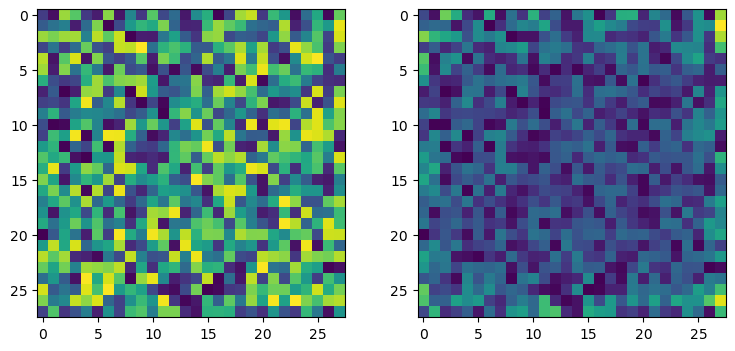

(0.0015087006877941844, 0.9982250618057277, 8.6623266e-05, 0.08863914)

In [18]:
gdng = GDNGaussian(filters=filters, kernel_size=kernel_size)

input_sample = np.random.random(size=(1, 28, 28, 1))
output_sample = gdng(input_sample).numpy()

fig, axes = plt.subplots(1,2, figsize=(9,4))
axes[0].imshow(input_sample.squeeze())
axes[1].imshow(output_sample.squeeze())
plt.show()

input_sample.min(), input_sample.max(), output_sample.min(), output_sample.max(), 

### RGB

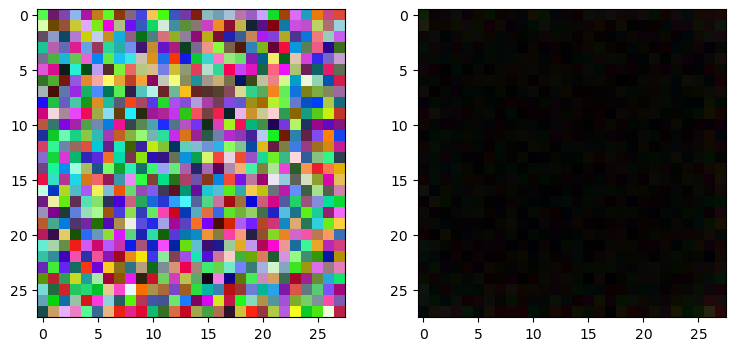

(0.0007600849987757785, 0.9995469475074411, 3.798289e-05, 0.16561173)

In [19]:
gdng = GDNGaussian(filters=filters, kernel_size=kernel_size)

input_sample = np.random.random(size=(1, 28, 28, 3))
output_sample = gdng(input_sample).numpy()

fig, axes = plt.subplots(1,2, figsize=(9,4))
axes[0].imshow(input_sample.squeeze())
axes[1].imshow(output_sample.squeeze())
plt.show()

input_sample.min(), input_sample.max(), output_sample.min(), output_sample.max(), 

So far so good.

# Train simple model

> Build a simple model with CIFAR10 to check its behavior.

In [6]:
from tensorflow.keras.datasets import cifar10

In [7]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [8]:
class GaussianParameterPerBatchCallback(tf.keras.callbacks.Callback):
    """Simple callback to print the values of the parameters of the RandomGaussian layer."""
    def on_train_batch_begin(self,
                             batch,
                             logs=None,
                             ):
        for layer in self.model.layers:
            if isinstance(layer, GDNGaussian):
                attrs = {k:v for k, v in layer.conv.__dict__.items() if k[0]!="_"}
                for name, value in attrs.items():
                    print(f"{name}: {value}")

In [15]:
model = tf.keras.Sequential([
    GDNGaussian(kernel_size=11, input_shape=X_train[0].shape),
    layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
    layers.MaxPool2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gdn_gaussian_5 (GDNGaussian) (None, 32, 32, 3)         381       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 1,607
Trainable params: 1,243
Non-trainable params: 364
_________________________________________________________________


In [16]:
history = model.fit(X_train, Y_train, epochs=5, batch_size=128, validation_split=0.2, callbacks=[GaussianParameterPerBatchCallback()])

Epoch 1/5
built: True
theta: [2.59658921 4.65368255 0.34435869]
filters: 3
size: 11
Nrows: 11
Ncols: 11
fs: 11
normalize: True
sigma_i: [0.19484678 0.8616556  0.05542421]
sigma_j: [0.18722038 0.4387191  0.2375857 ]
imean: <tf.Variable 'gdn_gaussian_5/random_gaussian_1/imean:0' shape=() dtype=float32, numpy=0.5>
jmean: <tf.Variable 'gdn_gaussian_5/random_gaussian_1/jmean:0' shape=() dtype=float32, numpy=0.5>
logsigma_i: <tf.Variable 'gdn_gaussian_5/random_gaussian_1/logsigma_i:0' shape=(3,) dtype=float32, numpy=array([-1.6355418 , -0.14889963, -2.8927388 ], dtype=float32)>
logsigma_j: <tf.Variable 'gdn_gaussian_5/random_gaussian_1/logsigma_j:0' shape=(3,) dtype=float32, numpy=array([-1.6754689 , -0.82389593, -1.4372269 ], dtype=float32)>
freq: <tf.Variable 'gdn_gaussian_5/random_gaussian_1/freq:0' shape=(3,) dtype=float32, numpy=array([10.604796 ,  8.602243 ,  7.6908445], dtype=float32)>
rot_theta: <tf.Variable 'gdn_gaussian_5/random_gaussian_1/rot_theta:0' shape=(3,) dtype=float32, num

InvalidArgumentError:  Input is not invertible.
	 [[{{node sequential_1/gdn_gaussian_5/random_gaussian_1/StatefulPartitionedCall/while_98/body/_235/while/StatefulPartitionedCall/PartitionedCall/MatrixInverse}}]] [Op:__inference_train_function_12544]

Function call stack:
train_function


In [ ]:
model = tf.keras.Sequential([
    # GDNGaussian(kernel_size=11, input_shape=X_train[0].shape),
    RandomGaussian(filters=3, size=11, input_shape=X_train[0].shape),
    layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
    layers.MaxPool2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()
history = model.fit(X_train, Y_train, epochs=5, batch_size=128, validation_split=0.2, callbacks=[GaussianParameterPerBatchCallback()])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_gaussian_25 (RandomGa (None, 32, 32, 3)         380       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
global_average_pooling2d_4 ( (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
Total params: 1,606
Trainable params: 1,243
Non-trainable params: 363
_________________________________________________________________
Epoch 1/5
313/313 [==============================] - 12s 25ms/step - loss: 230.0957 - accuracy: 0.1032 - val_loss: 4

## Tracking the outputs of each layer

In [ ]:
import keract

In [ ]:
model = tf.keras.Sequential([
    GDNGaussian(kernel_size=11, input_shape=X_train[0].shape),
    # RandomGaussian(filters=3, size=11, input_shape=X_train[0].shape),
    layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
    layers.MaxPool2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
# model.summary()


# history = model.fit(X_train, Y_train, epochs=5, batch_size=128, validation_split=0.2)

In [ ]:
activations = keract.get_activations(model, X_train[:1], layer_names=None, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)

In [ ]:
activations.keys()

odict_keys(['gdn_gaussian_14_input', 'gdn_gaussian_14', 'conv2d_10', 'max_pooling2d_10', 'global_average_pooling2d_10', 'dense_10'])

gdn_gaussian_14_input (1, 32, 32, 3) 


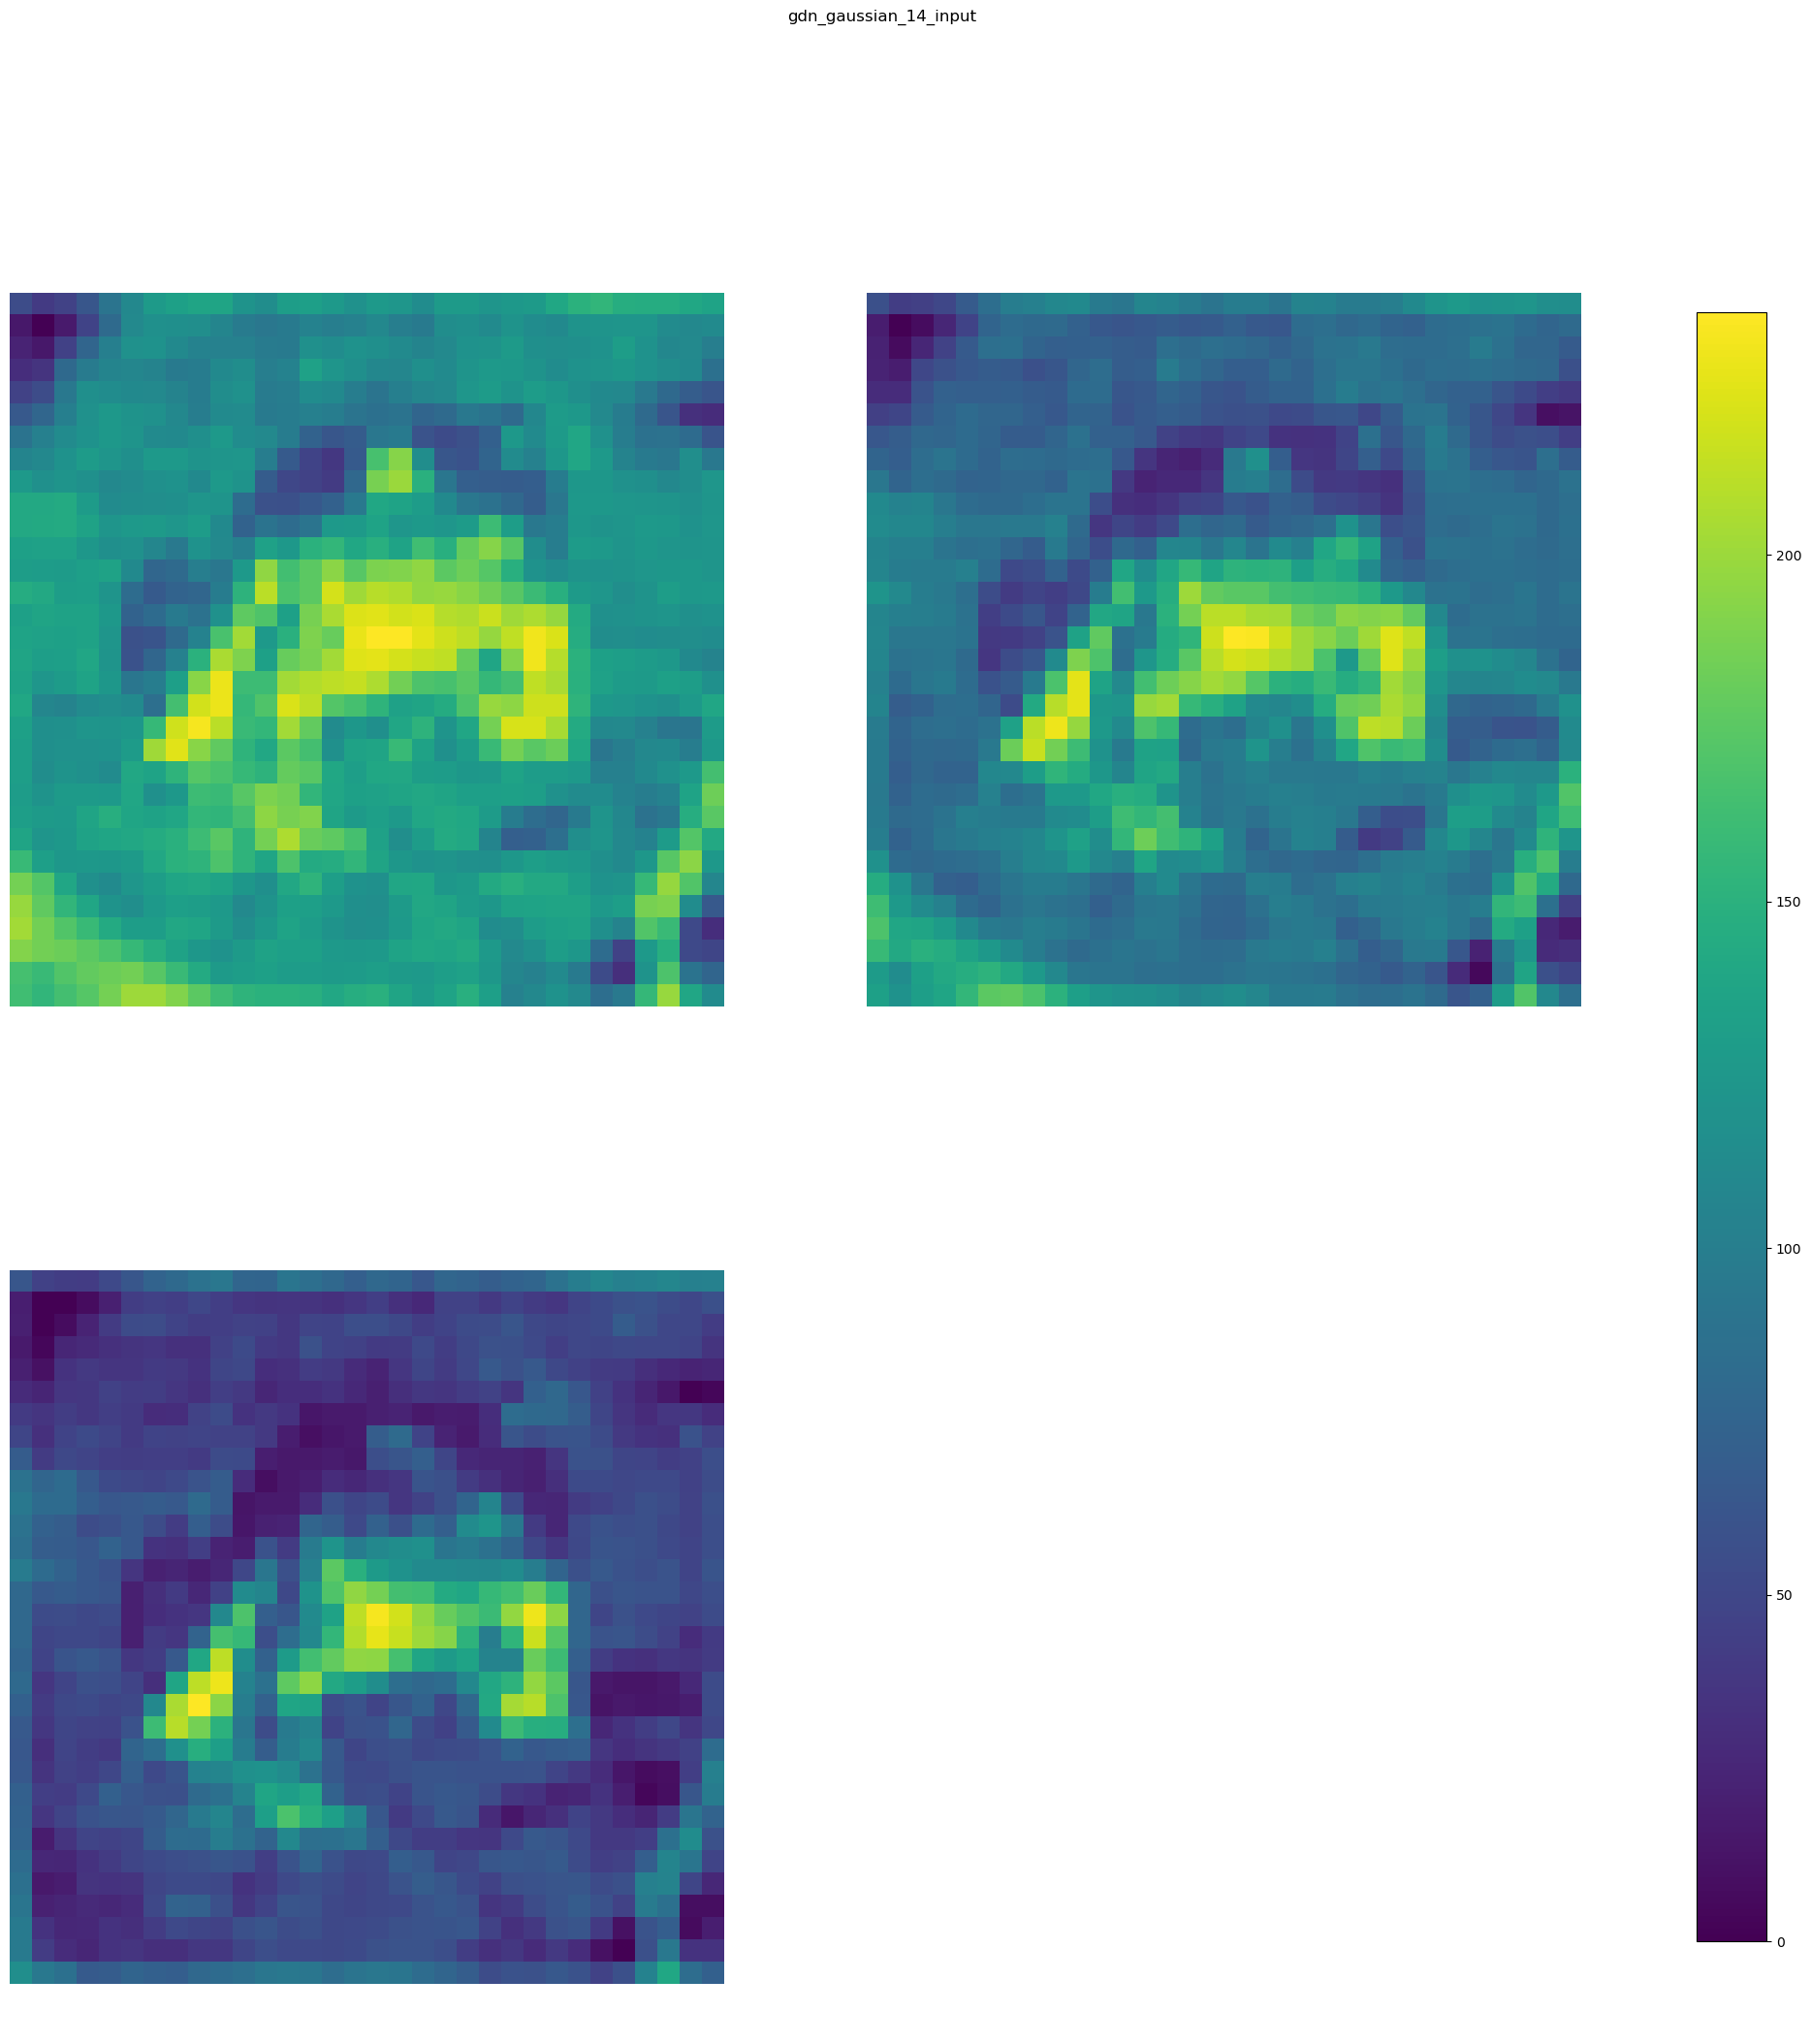

gdn_gaussian_14 (1, 32, 32, 3) 


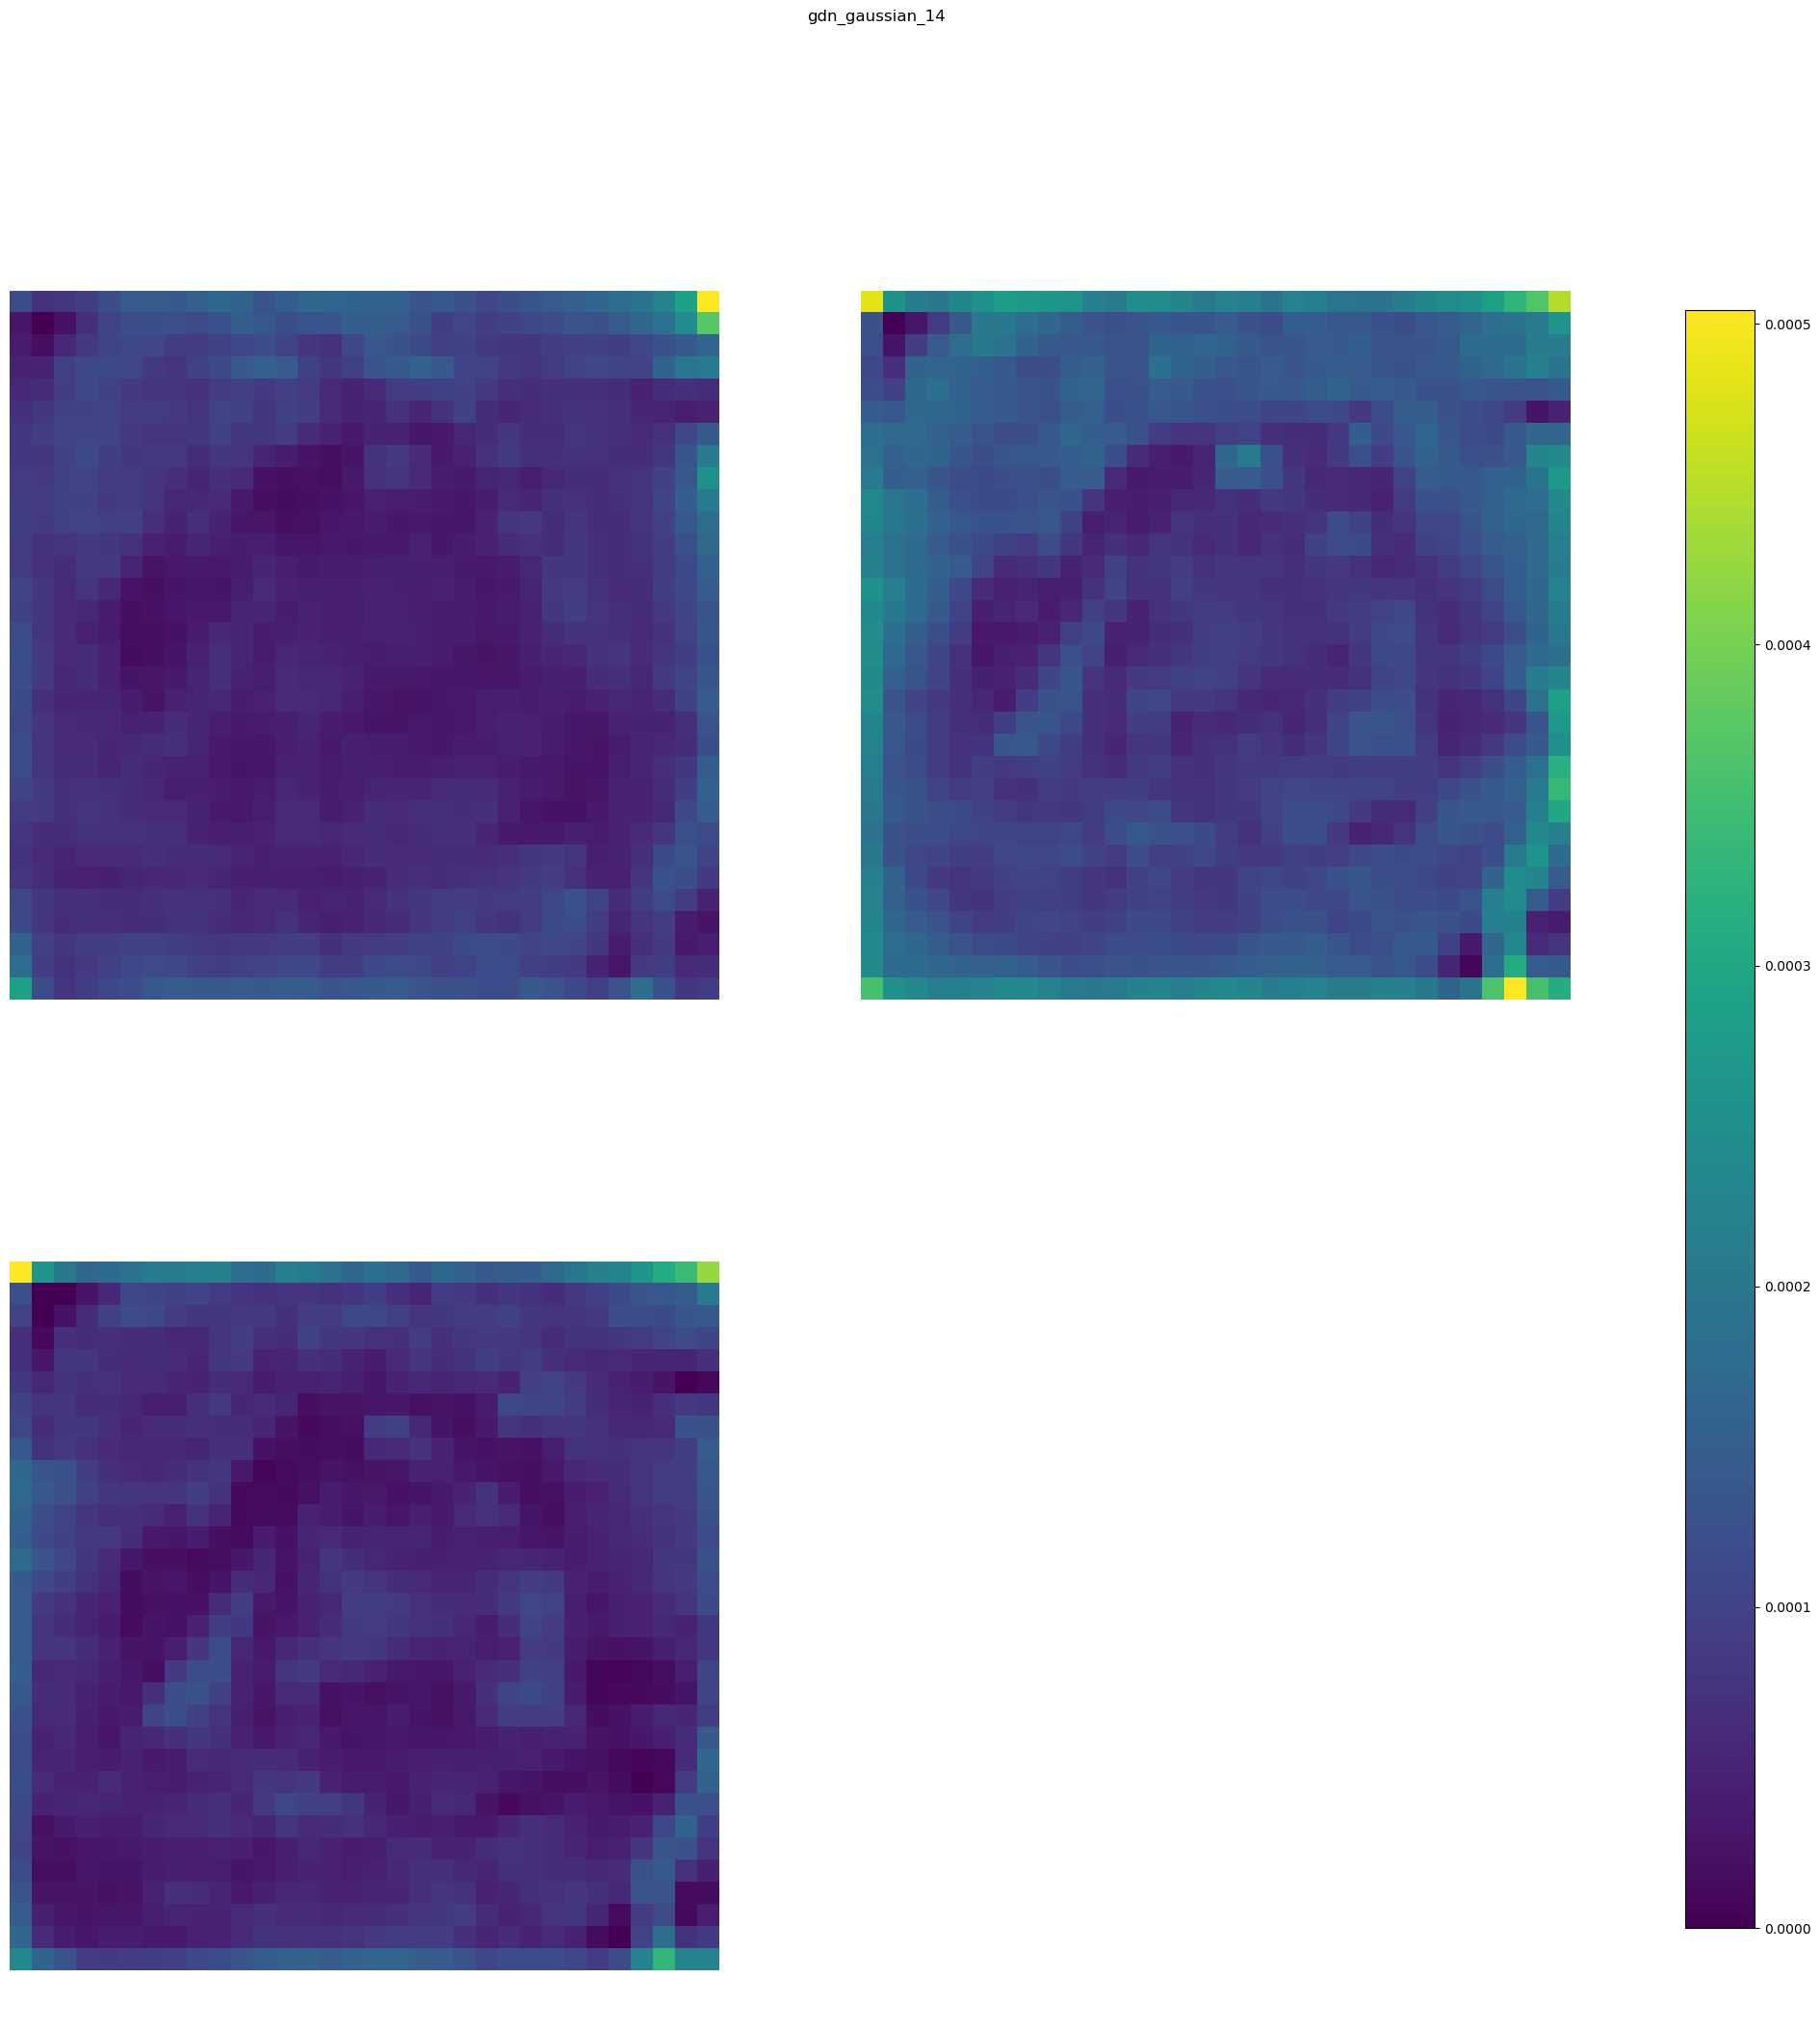

conv2d_10 (1, 30, 30, 32) 


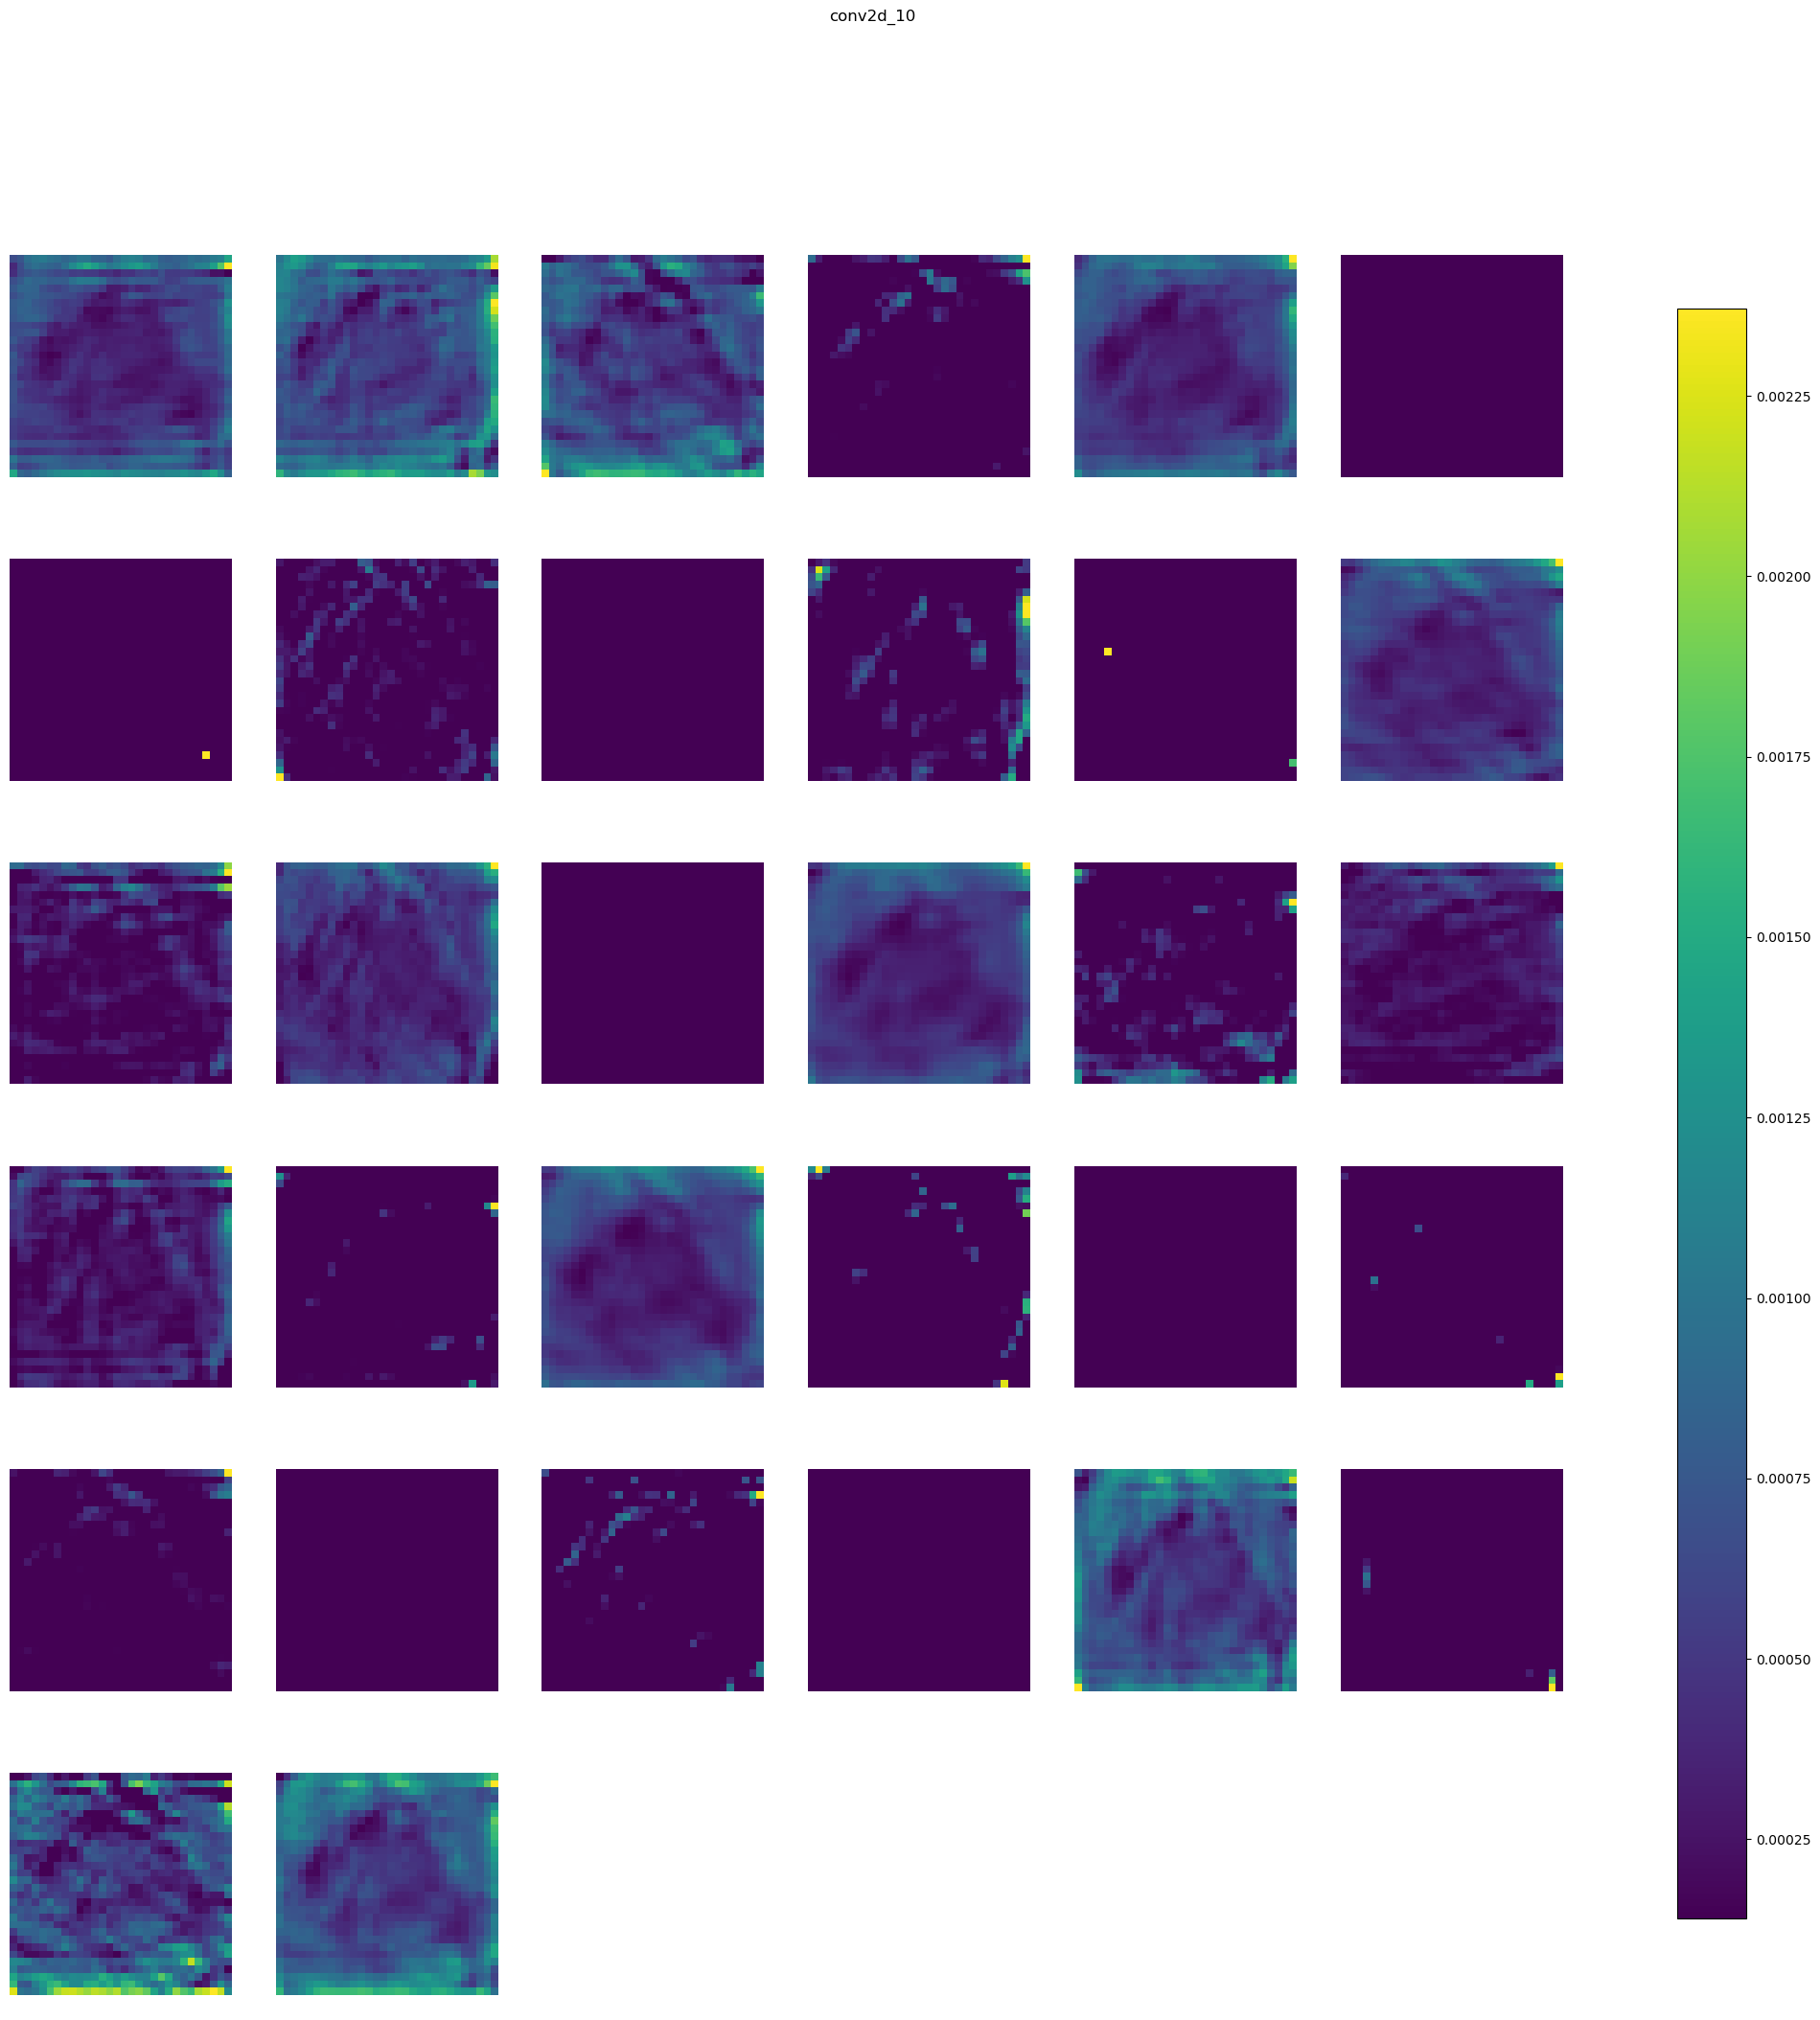

max_pooling2d_10 (1, 15, 15, 32) 


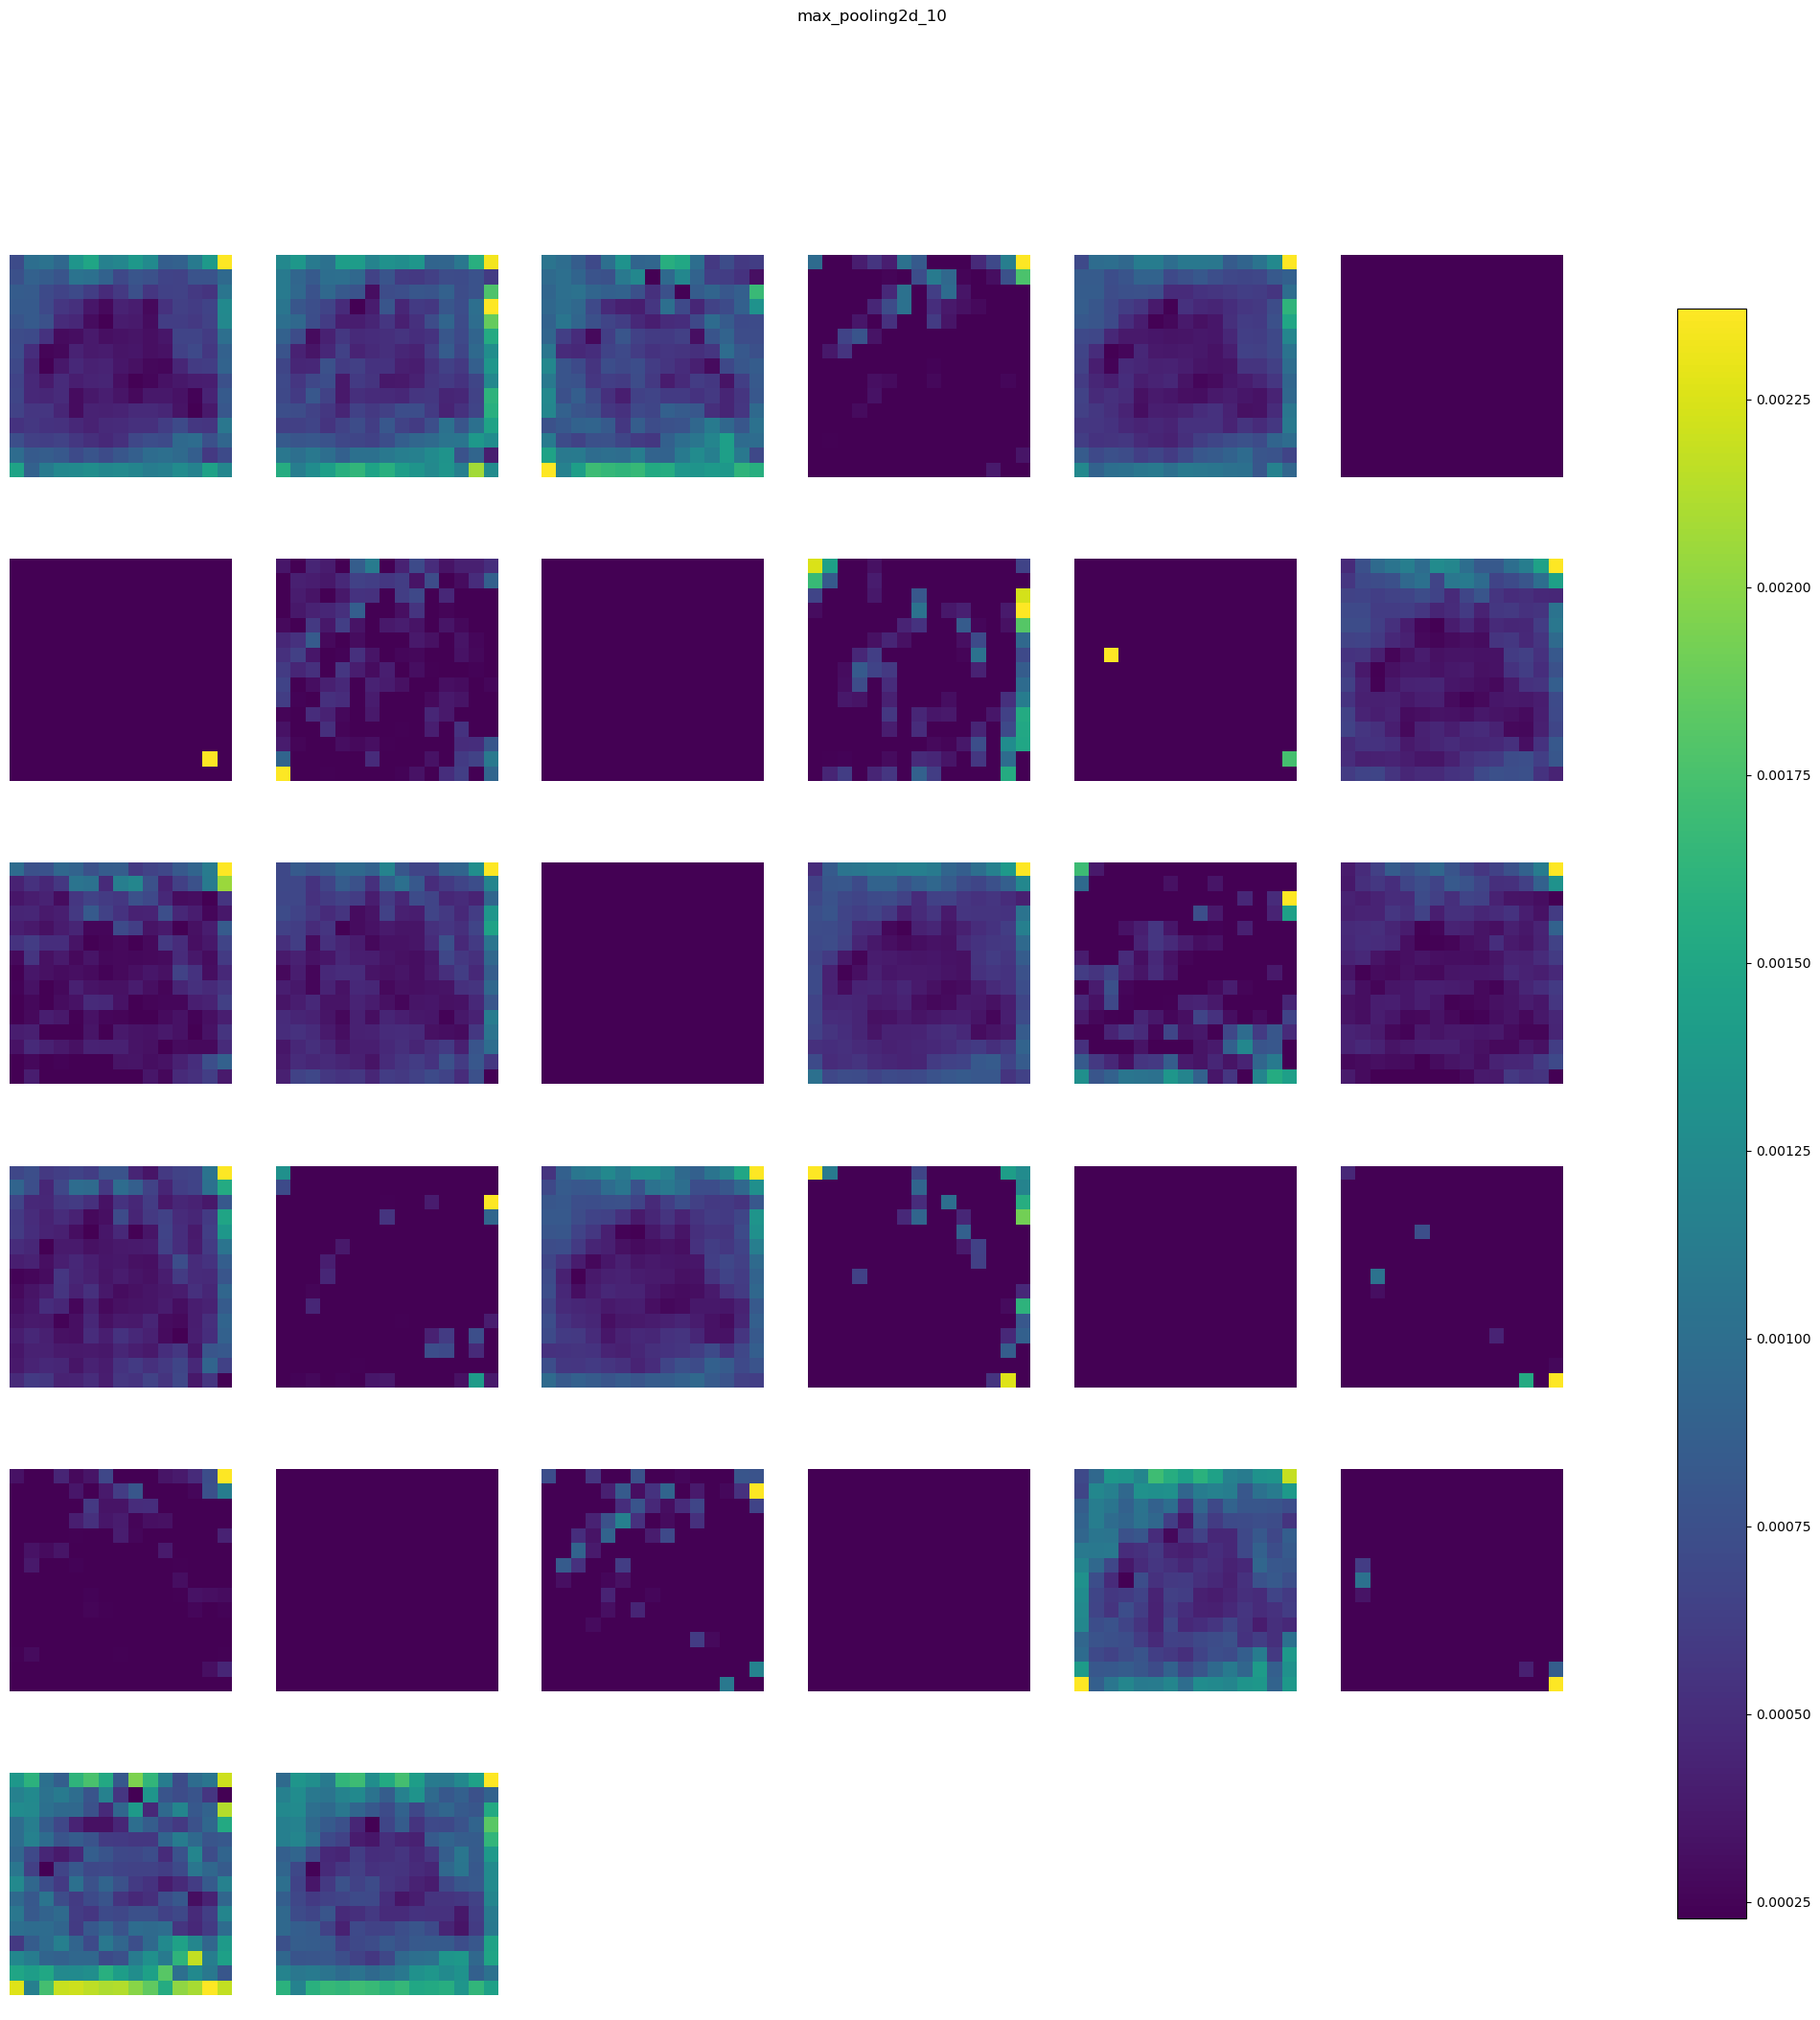

global_average_pooling2d_10 (1, 32) 


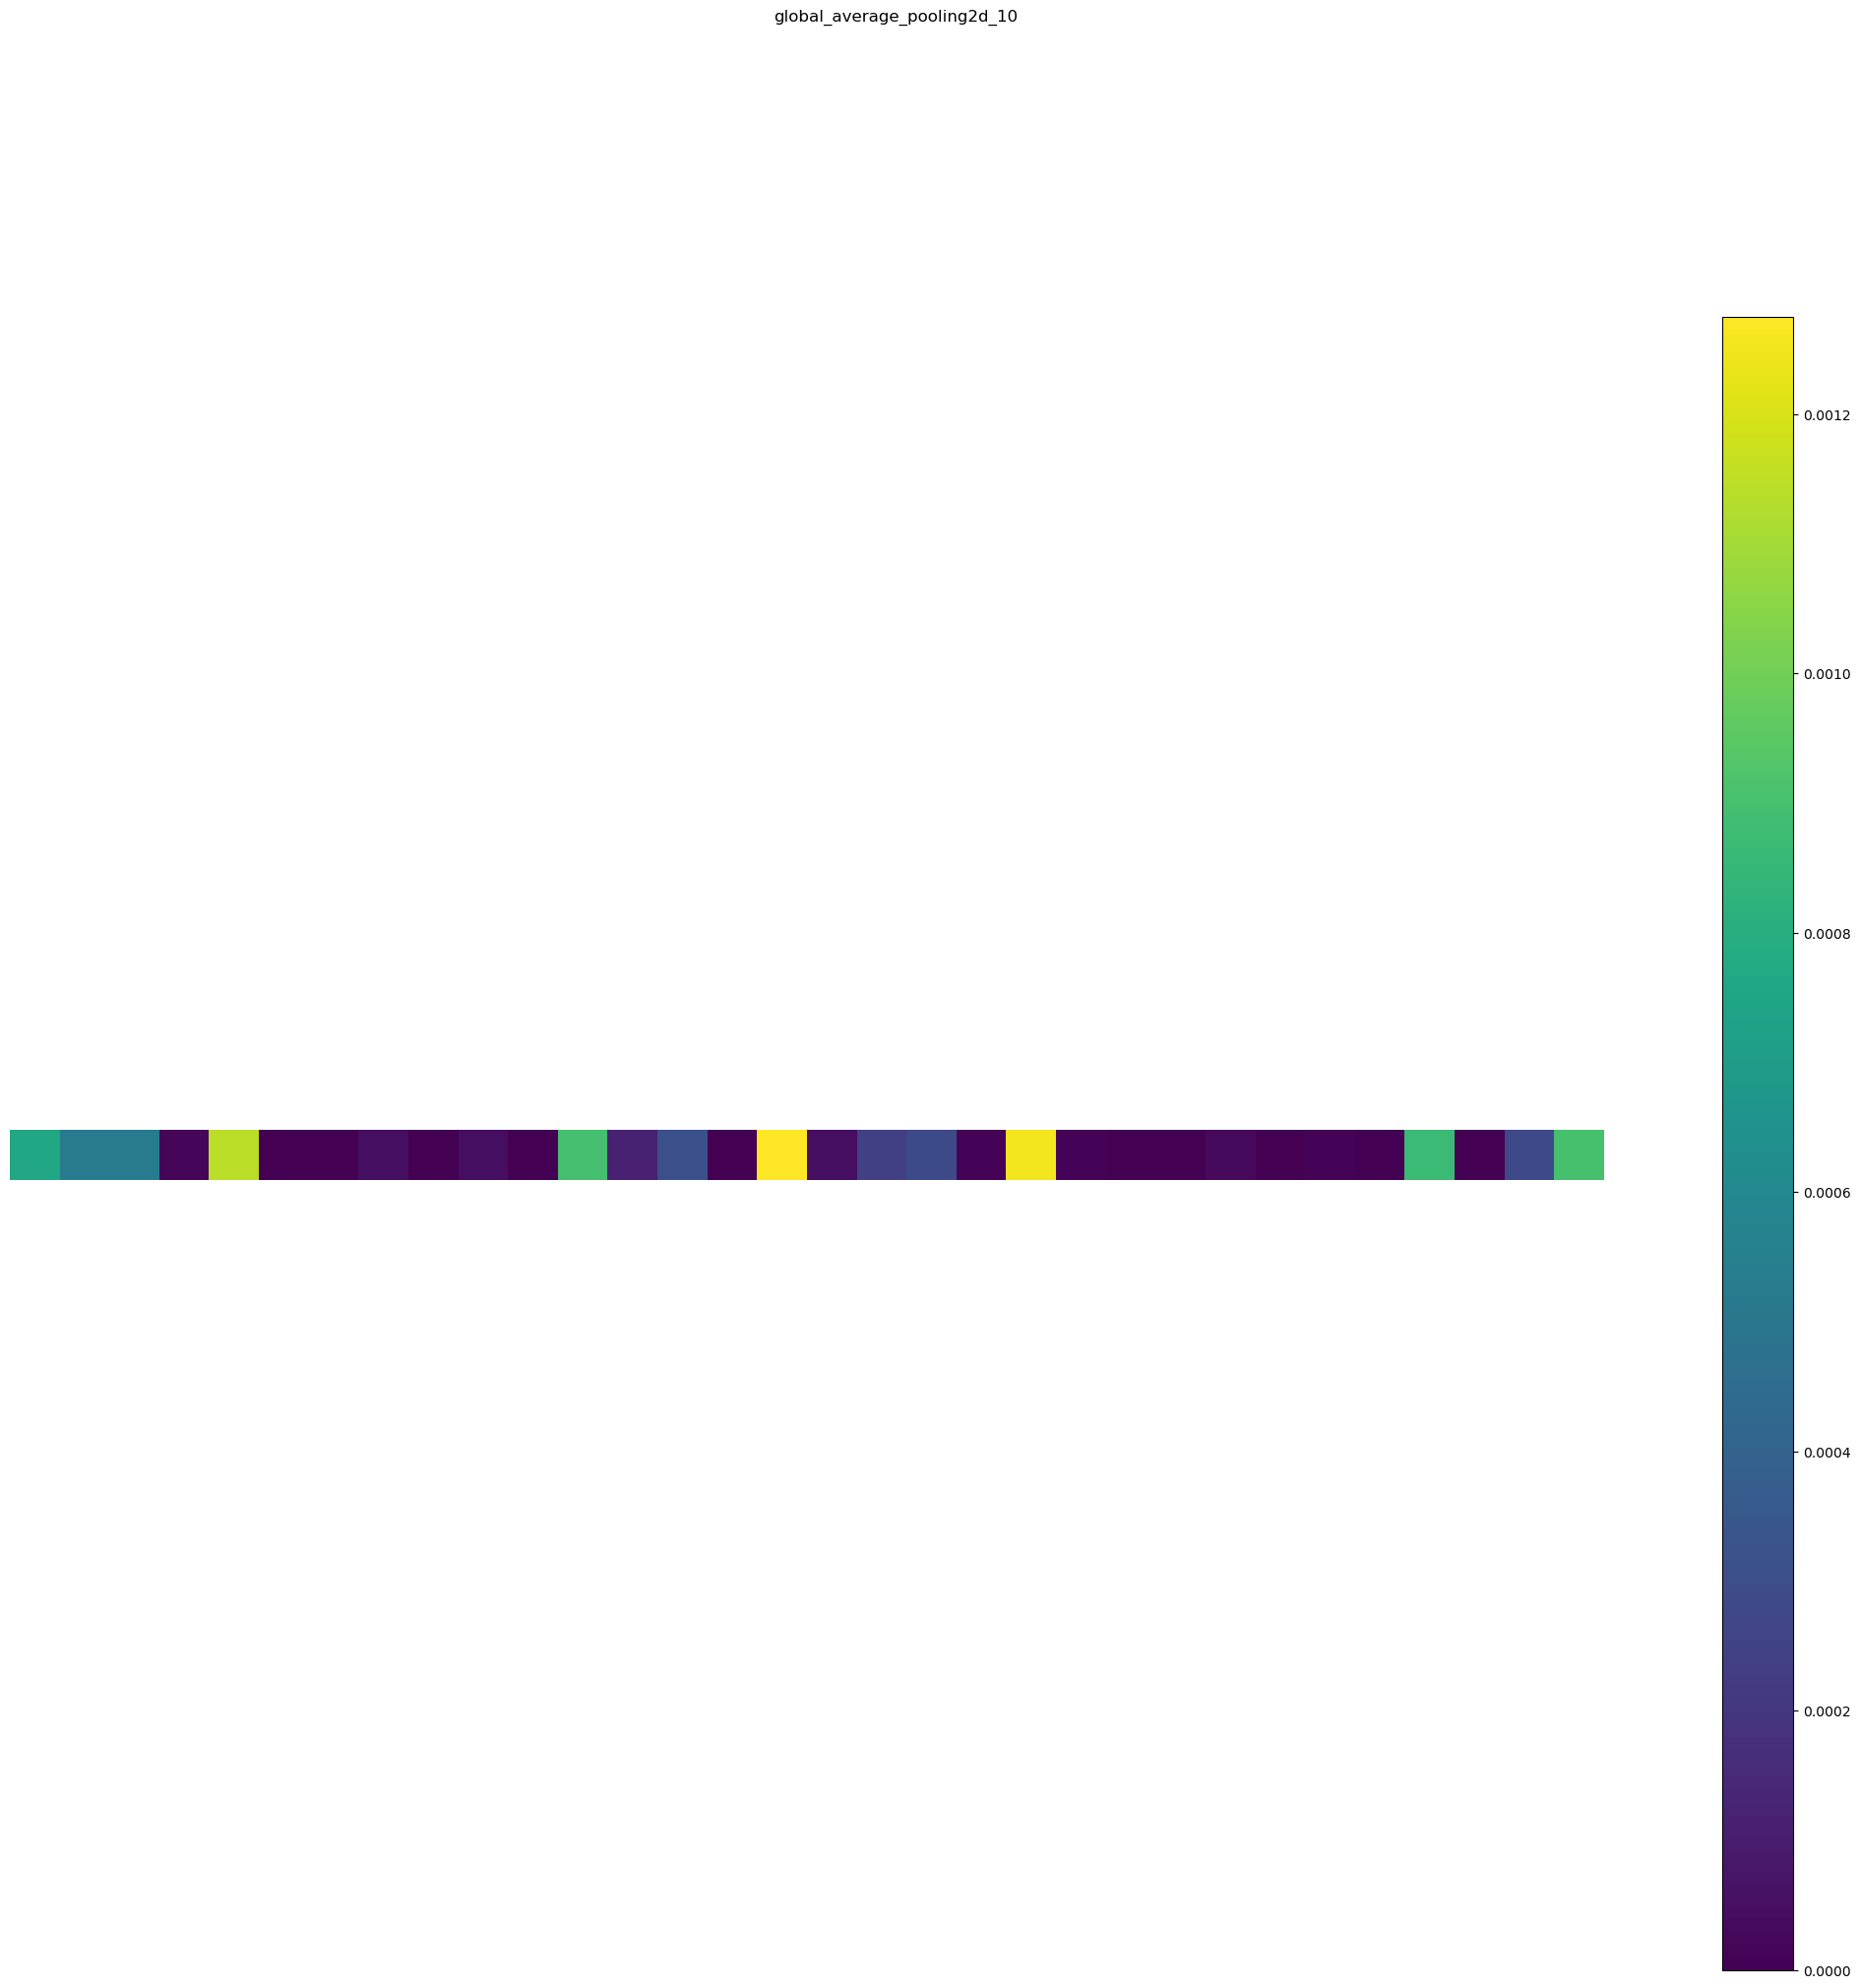

dense_10 (1, 10) 


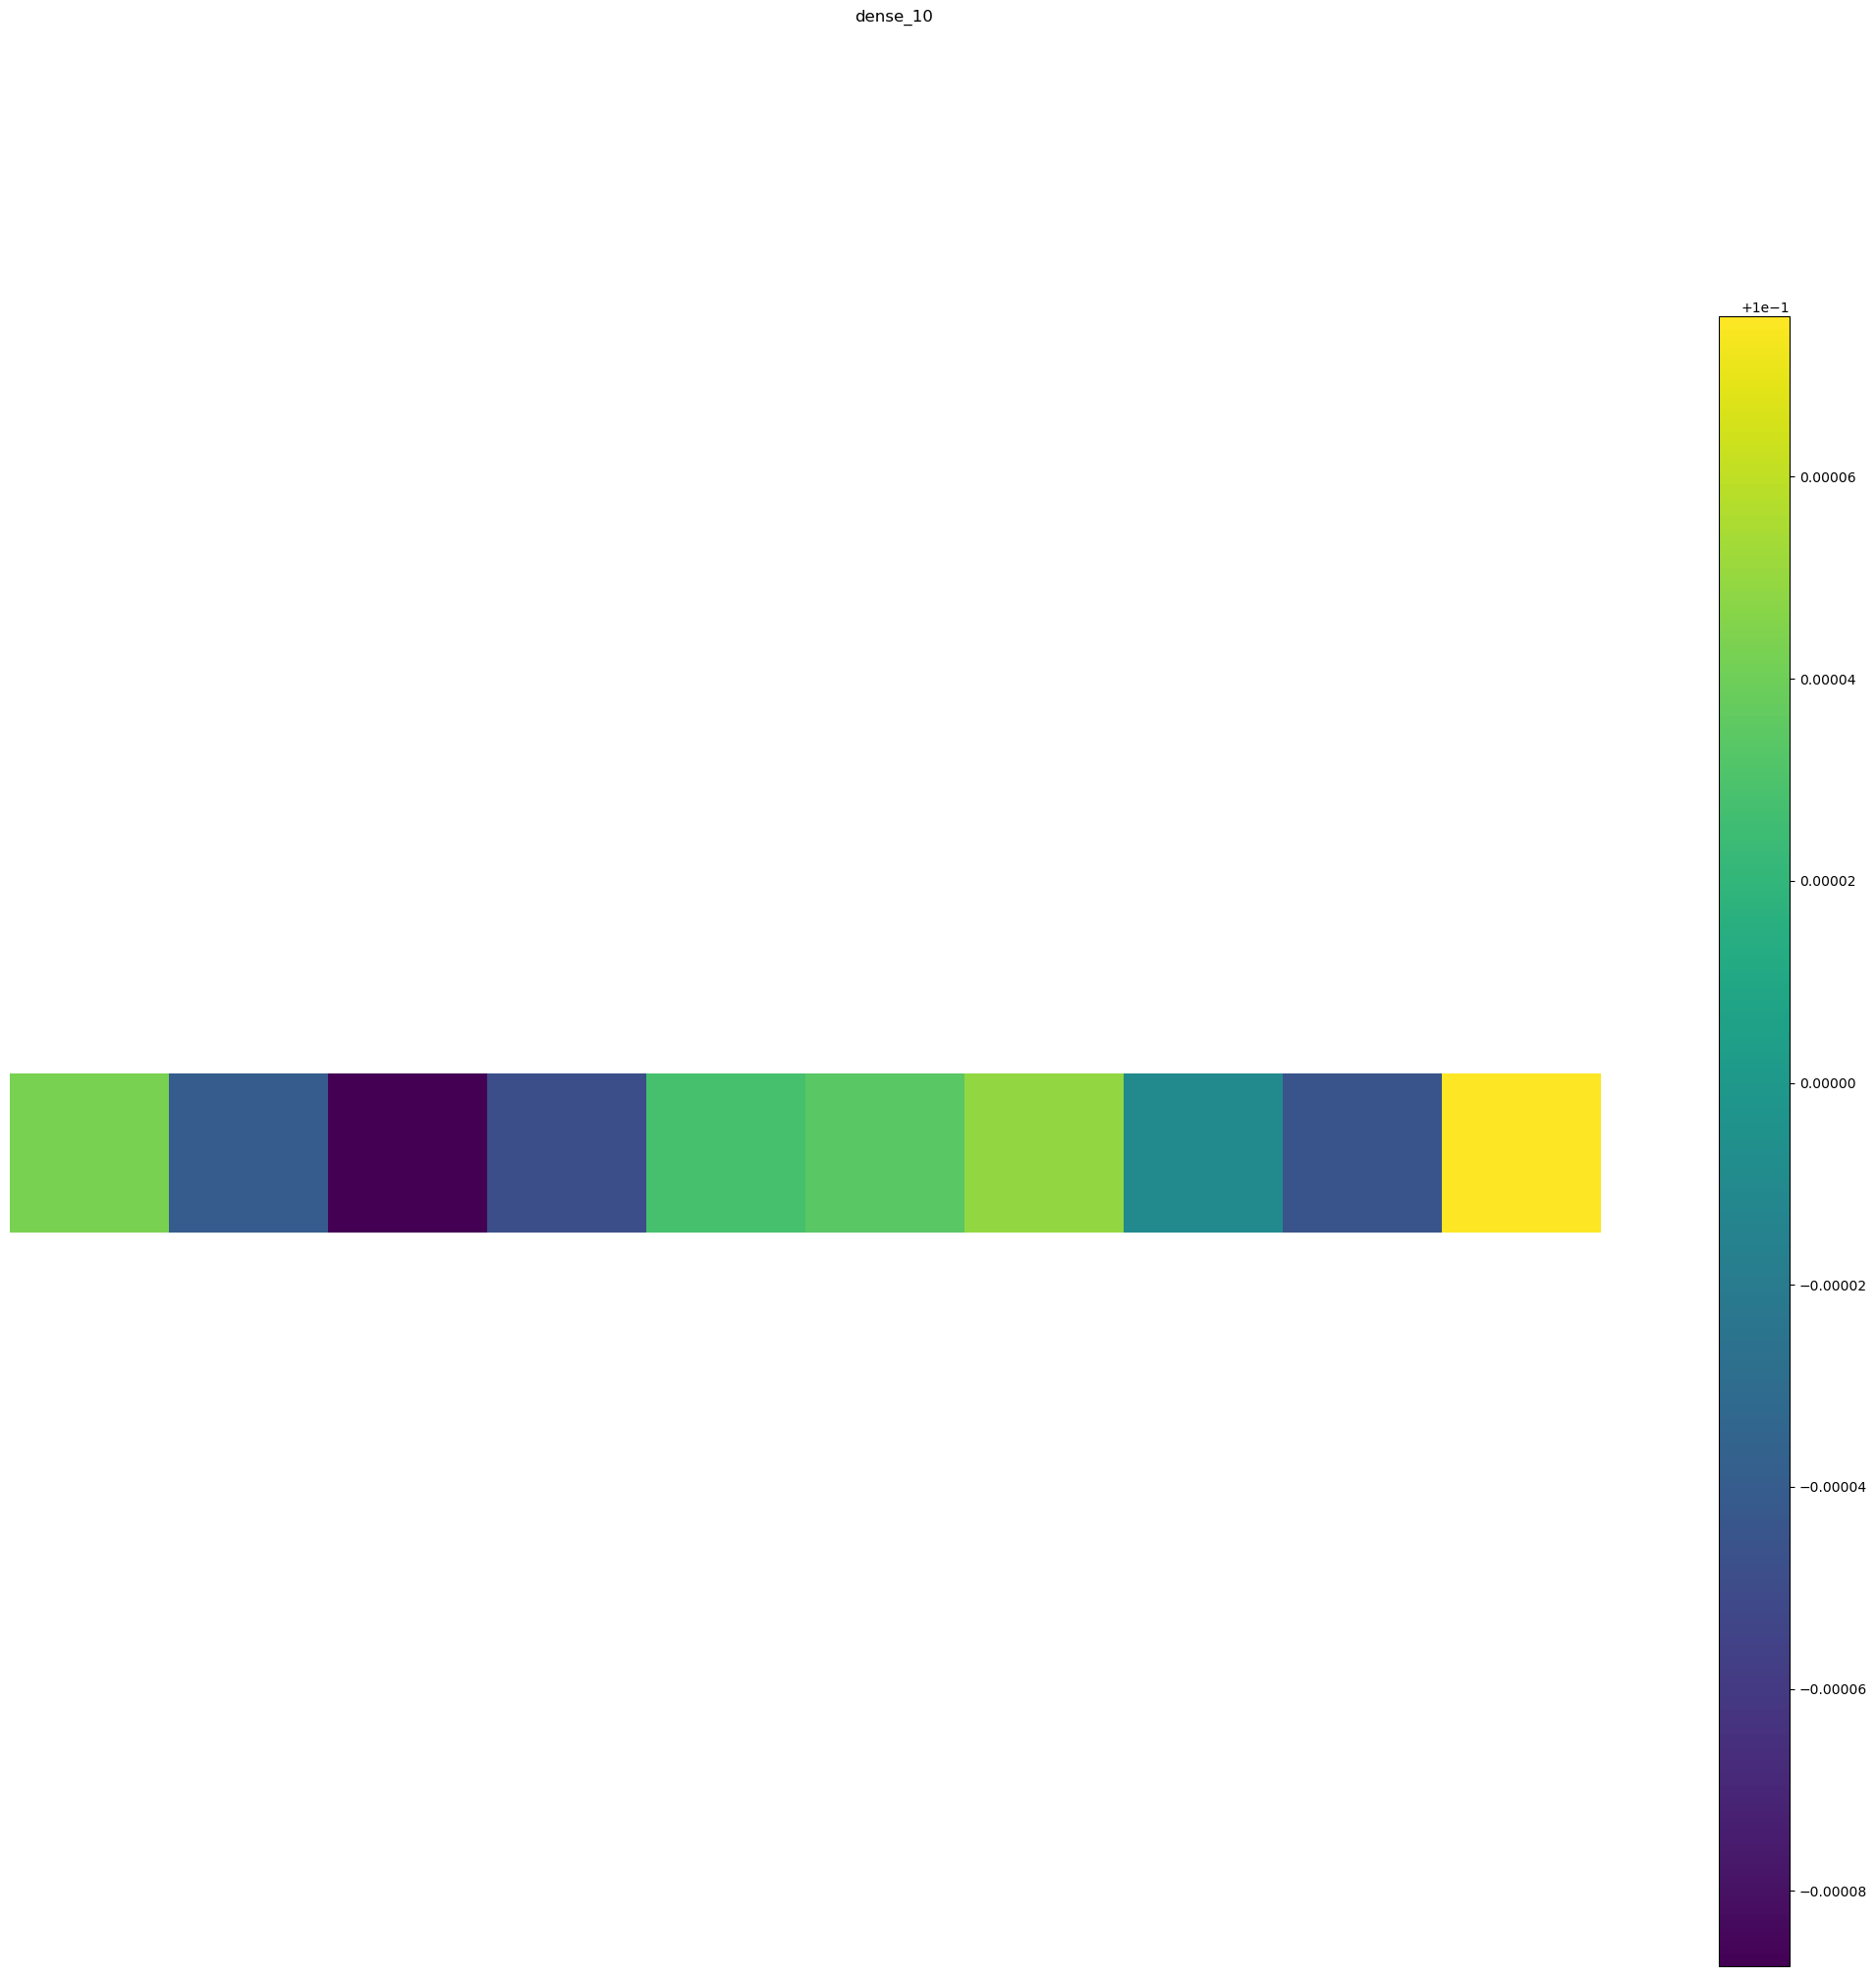

In [ ]:
keract.display_activations(activations, cmap=None, save=False, directory='.', data_format='channels_last', fig_size=(24, 24), reshape_1d_layers=False)

In [ ]:
activations.keys()

odict_keys(['gdn_gaussian_14_input', 'gdn_gaussian_14', 'conv2d_10', 'max_pooling2d_10', 'global_average_pooling2d_10', 'dense_10'])

In [ ]:
activations["gdn_gaussian_14"].squeeze().min(), activations["gdn_gaussian_14"].squeeze().max()

(0.0, 0.018113762)

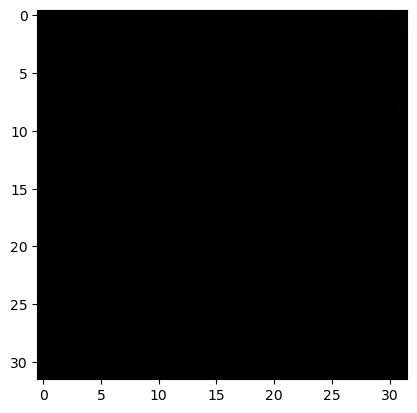

In [ ]:
plt.imshow(activations["gdn_gaussian_14"].squeeze(), vmin=activations["gdn_gaussian_14"].squeeze().min(), vmax=activations["gdn_gaussian_14"].squeeze().max())
plt.show()

## Tracking gradients

In [87]:
model = tf.keras.Sequential([
    GDNGaussian(kernel_size=11, input_shape=X_train[0].shape),
    # RandomGaussian(filters=3, size=11, input_shape=X_train[0].shape),
    layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
    layers.MaxPool2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
# model.summary()


# history = model.fit(X_train, Y_train, epochs=5, batch_size=128, validation_split=0.2)

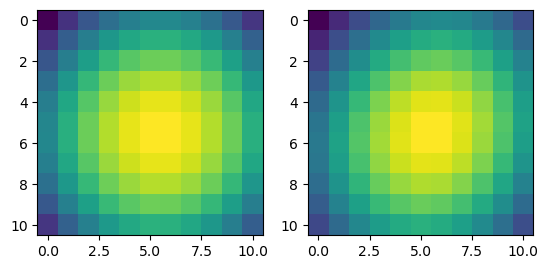

In [88]:
model.layers[0].conv.show_filters()

In [89]:
with tf.GradientTape() as tape:
    output = model(X_train[:32], training=True)
    loss = tf.reduce_mean(tf.losses.sparse_categorical_crossentropy(Y_train[:32], output))

In [90]:
gradients = tape.gradient(loss, model.trainable_variables)

Now we have to map the gradients to the trainable variables in the model:

In [91]:
grads = {}
for train_var, grad in zip(model.trainable_variables, gradients):
    grads[train_var.name] = grad

Filter them to only show the ones related to the gdn:

In [92]:
model.optimizer.learning_rate.assign(0.1)
model.optimizer.learning_rate

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.1>

In [93]:
grads_gdn = {k:v for k,v in grads.items() if k.find("gdn")!=-1}

In [94]:
og_train_vars = model.layers[0].trainable_variables.copy()
og_train_vars

[<tf.Variable 'gdn_gaussian_11/random_gaussian_1/imean:0' shape=() dtype=float32, numpy=0.5>,
 <tf.Variable 'gdn_gaussian_11/random_gaussian_1/jmean:0' shape=() dtype=float32, numpy=0.5>,
 <tf.Variable 'gdn_gaussian_11/random_gaussian_1/logsigma_i:0' shape=(3,) dtype=float32, numpy=array([-0.11075918, -0.6599963 , -0.699458  ], dtype=float32)>,
 <tf.Variable 'gdn_gaussian_11/random_gaussian_1/logsigma_j:0' shape=(3,) dtype=float32, numpy=array([-0.12238272, -0.53088623, -0.5464002 ], dtype=float32)>,
 <tf.Variable 'gdn_gaussian_11/random_gaussian_1/freq:0' shape=(3,) dtype=float32, numpy=array([10.15932   ,  0.15312615, 10.420742  ], dtype=float32)>,
 <tf.Variable 'gdn_gaussian_11/random_gaussian_1/rot_theta:0' shape=(3,) dtype=float32, numpy=array([1.5536385, 3.355269 , 2.221339 ], dtype=float32)>,
 <tf.Variable 'gdn_gaussian_11/random_gaussian_1/sigma_theta:0' shape=(3,) dtype=float32, numpy=array([3.525979  , 3.8038464 , 0.79182434], dtype=float32)>]

In [95]:
grads_gdn

{'gdn_gaussian_11/random_gaussian_1/imean:0': <tf.Tensor: shape=(), dtype=float32, numpy=2.3117939e-06>,
 'gdn_gaussian_11/random_gaussian_1/jmean:0': <tf.Tensor: shape=(), dtype=float32, numpy=1.641095e-06>,
 'gdn_gaussian_11/random_gaussian_1/logsigma_i:0': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-6.0328034e-07, -1.7162149e-06, -1.8676197e-06], dtype=float32)>,
 'gdn_gaussian_11/random_gaussian_1/logsigma_j:0': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-6.9709961e-07, -1.2760349e-06, -1.5168479e-06], dtype=float32)>,
 'gdn_gaussian_11/random_gaussian_1/freq:0': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>,
 'gdn_gaussian_11/random_gaussian_1/rot_theta:0': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.6949437e-09, -1.4651050e-08,  5.9495164e-09], dtype=float32)>,
 'gdn_gaussian_11/random_gaussian_1/sigma_theta:0': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 1.69492864e-09,  1.46509365e-08, -5.94968697e-09], dt

Size of the gradient with respect to the original value:

In [96]:
grads_respect = {}
for train_var in model.layers[0].trainable_variables:
    grads_respect[train_var.name] = grads_gdn[train_var.name]/train_var

In [97]:
grads_respect

{'gdn_gaussian_11/random_gaussian_1/imean:0': <tf.Tensor: shape=(), dtype=float32, numpy=4.6235878e-06>,
 'gdn_gaussian_11/random_gaussian_1/jmean:0': <tf.Tensor: shape=(), dtype=float32, numpy=3.28219e-06>,
 'gdn_gaussian_11/random_gaussian_1/logsigma_i:0': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([5.4467750e-06, 2.6003404e-06, 2.6700957e-06], dtype=float32)>,
 'gdn_gaussian_11/random_gaussian_1/logsigma_j:0': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([5.6960625e-06, 2.4035940e-06, 2.7760750e-06], dtype=float32)>,
 'gdn_gaussian_11/random_gaussian_1/freq:0': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>,
 'gdn_gaussian_11/random_gaussian_1/rot_theta:0': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.0909512e-09, -4.3665800e-09,  2.6783469e-09], dtype=float32)>,
 'gdn_gaussian_11/random_gaussian_1/sigma_theta:0': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 4.806973e-10,  3.851611e-09, -7.513898e-09], dtype=float32)>

Apply the optimization:

In [98]:
model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

And check the values after the change:

In [99]:
og_train_vars

[<tf.Variable 'gdn_gaussian_11/random_gaussian_1/imean:0' shape=() dtype=float32, numpy=0.4577672>,
 <tf.Variable 'gdn_gaussian_11/random_gaussian_1/jmean:0' shape=() dtype=float32, numpy=0.46583366>,
 <tf.Variable 'gdn_gaussian_11/random_gaussian_1/logsigma_i:0' shape=(3,) dtype=float32, numpy=array([-0.09473778, -0.6248162 , -0.6623267 ], dtype=float32)>,
 <tf.Variable 'gdn_gaussian_11/random_gaussian_1/logsigma_j:0' shape=(3,) dtype=float32, numpy=array([-0.10431978, -0.50213504, -0.513982  ], dtype=float32)>,
 <tf.Variable 'gdn_gaussian_11/random_gaussian_1/freq:0' shape=(3,) dtype=float32, numpy=array([10.15932   ,  0.15312615, 10.420742  ], dtype=float32)>,
 <tf.Variable 'gdn_gaussian_11/random_gaussian_1/rot_theta:0' shape=(3,) dtype=float32, numpy=array([1.553692, 3.35573 , 2.221151], dtype=float32)>,
 <tf.Variable 'gdn_gaussian_11/random_gaussian_1/sigma_theta:0' shape=(3,) dtype=float32, numpy=array([3.5259254 , 3.8033853 , 0.79201216], dtype=float32)>]

In [100]:
model.layers[0].trainable_variables

[<tf.Variable 'gdn_gaussian_11/random_gaussian_1/imean:0' shape=() dtype=float32, numpy=0.4577672>,
 <tf.Variable 'gdn_gaussian_11/random_gaussian_1/jmean:0' shape=() dtype=float32, numpy=0.46583366>,
 <tf.Variable 'gdn_gaussian_11/random_gaussian_1/logsigma_i:0' shape=(3,) dtype=float32, numpy=array([-0.09473778, -0.6248162 , -0.6623267 ], dtype=float32)>,
 <tf.Variable 'gdn_gaussian_11/random_gaussian_1/logsigma_j:0' shape=(3,) dtype=float32, numpy=array([-0.10431978, -0.50213504, -0.513982  ], dtype=float32)>,
 <tf.Variable 'gdn_gaussian_11/random_gaussian_1/freq:0' shape=(3,) dtype=float32, numpy=array([10.15932   ,  0.15312615, 10.420742  ], dtype=float32)>,
 <tf.Variable 'gdn_gaussian_11/random_gaussian_1/rot_theta:0' shape=(3,) dtype=float32, numpy=array([1.553692, 3.35573 , 2.221151], dtype=float32)>,
 <tf.Variable 'gdn_gaussian_11/random_gaussian_1/sigma_theta:0' shape=(3,) dtype=float32, numpy=array([3.5259254 , 3.8033853 , 0.79201216], dtype=float32)>]

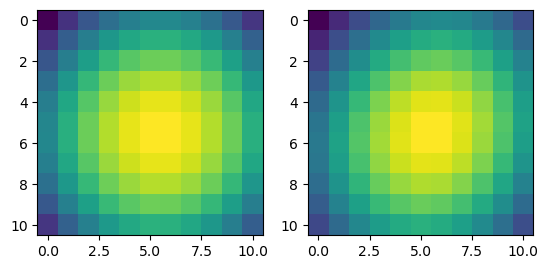

In [101]:
model.layers[0].conv.show_filters()

In [102]:
tf.exp(model.layers[0].conv.logsigma_i), tf.exp(model.layers[0].conv.logsigma_j)

(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.90961146, 0.5353598 , 0.51565015], dtype=float32)>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.9009372 , 0.60523707, 0.5981092 ], dtype=float32)>)